In [28]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import norm
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 50)


In [29]:
def clean_merged_data(merged_data, preference="patience"):
    ## drop the columns with all NaN values
    NaN_columns = merged_data.columns[merged_data.isnull().all()]        
    df = merged_data.drop(NaN_columns, axis=1,)[["country", preference, "age"]]

    ## replace "99 99+" with 99 and fill the missing values with 0 and convert the age variable into integer
    df["age"] = df["age"].replace({"99 99+": 99}).fillna(0).astype(int)

    return df

In [30]:
directory_path= r"C:\Users\Mumu\Desktop\Bonn Econ\RM_applied_micro\GIthub_new\rm-applied-micro\merged_gps_gallup.csv"
merged_data = pd.read_csv(directory_path)

### Generate a new dataframe with age group (young/old)
df_split = clean_merged_data(merged_data)

df_split["age_group"] = np.where(df_split['age'] >= df_split['age'].median(), "Above_40", "Below_40")
#df_split = split_into_quantiles(df_split)
#qage_counts = df_split.groupby(["country", "qage"]).size().reset_index(name="Observation Count")
df_groups = df_split.groupby(["country", "age_group"]).mean("patience").reset_index()
df_groups = df_groups.rename(columns={"patience": "patience_mean"})
#only keep the columns: country, qage_labels, patience_mean
df_groups = df_groups[["country", "age_group", "patience_mean"]]

C:\Users\Mumu\AppData\Local\Temp\ipykernel_13704\1616364029.py:2: DtypeWarning: Columns (16,63,66,68,69,71,72,75,79,80,81,82,83,84,86,88,90,91,94,96,97,99,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,120,121,125,126,129,131,137,138,139,142,144,147,148,149,154,159,163,165,166,168,170,171,173,174,175,178,184,186,187,188,189,190,191,192,193,194,195,198,200,201,202,203,204,205,206,208,209,210,211,213,214,215,216,218,221,222,224,226,231,232,233,237,239,240,241,242,245,246,247,248,252,254,256,260,261,262,263,265,267,268,272,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,354,355,356,357,359,366,368,370,371,372,373,374,375,377,378,379,380,381,382,383,384,386,387,389,395,396,397,398,399,400,401,406,407,413,414,415,416,417,418,419,420,421,422,423,4

In [31]:
#groupby for each age group
df_below_40 = df_groups[df_groups["age_group"] == "Below_40"]
df_above_40 = df_groups[df_groups["age_group"] == "Above_40"]
#load the country mean data
dta_file= r"C:\Users\Mumu\Desktop\Bonn Econ\RM_applied_micro\GIthub_new\rm-applied-micro\country.dta"
#read the stata file
country_mean = pd.read_stata(dta_file)

In [32]:
#select country and mean patience 
country_mean = country_mean[["country", "patience"]].sort_values(by="patience", ascending=True).reset_index(drop=True)
country_mean.rename(columns={"patience": "patience_country"}, inplace=True)
#merge country mean, above 40 and below 40	
df_merged_below_40 = pd.merge(country_mean, df_below_40,  on="country", how="left")
df_merged_below_40.rename(columns={"patience_mean": "patience_below_40"}, inplace=True)
df_merged_below_above_40 = pd.merge(df_merged_below_40, df_above_40,  on="country", how="left")
df_merged_below_above_40.rename(columns={"patience_mean": "patience_above_40"}, inplace=True)
#drop columns that are not necessary
df_merged_below_above_40.drop(["age_group_x", "age_group_y"], axis=1, inplace=True)
df_merged_below_above_40.set_index("country", inplace=True)

In [33]:
#get ranking of patience for below 40 and above 40
df_merged_below_above_40["rank_below_40"] = df_merged_below_above_40["patience_below_40"].rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
df_merged_below_above_40["rank_above_40"] = df_merged_below_above_40["patience_above_40"].rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
df_merged_below_above_40.head()

,patience_country,patience_below_40,patience_above_40,rank_below_40,rank_above_40
country,,,,,
Nicaragua,-0.61,-0.59,-0.69,75,76
Rwanda,-0.61,-0.62,-0.63,76,75
Georgia,-0.49,-0.42,-0.55,74,73
Hungary,-0.43,-0.19,-0.61,56,74
Cameroon,-0.43,-0.42,-0.38,73,60


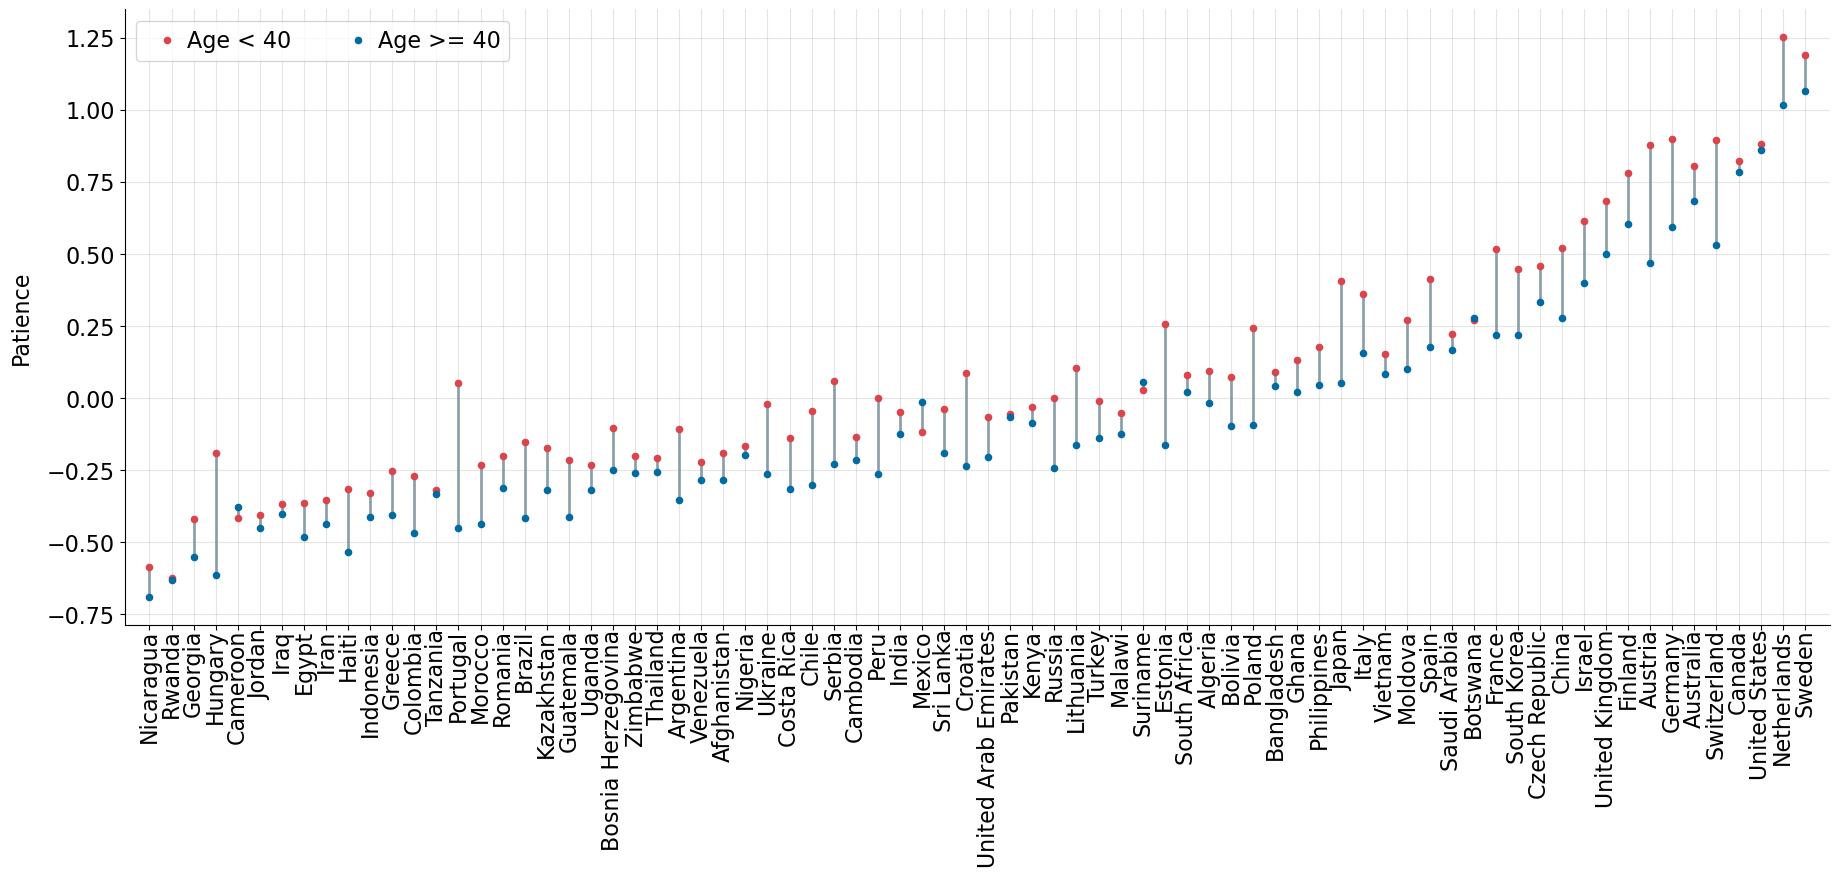

In [34]:
#plot the patience measure for below 40 and above 40
fig, ax = plt.subplots(figsize=(22, 8))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right']].set_visible(False)

# Plot data
# Plot horizontal lines first
ax.vlines(x=df_merged_below_above_40.index, ymin=df_merged_below_above_40["patience_below_40"], ymax=df_merged_below_above_40["patience_above_40"], color='#758D99', zorder=2, linewidth=2, label='_nolegend_', alpha=.8)
# Plot bubbles next
ax.scatter(df_merged_below_above_40.index, df_merged_below_above_40["patience_below_40"], label='Age < 40', s=20, color='#DB444B', zorder=3)
ax.scatter(df_merged_below_above_40.index, df_merged_below_above_40["patience_above_40"], label='Age >= 40', s=20, color='#006BA2', zorder=3)


# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labeltop=False,      # Put x-axis labels on top
                         labelbottom=True,  # Set no x-axis labels on bottom
                         bottom=True,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1,              # Lower tick labels a bit
                         rotation=90,
                         )            


# Set Legend
ax.legend(['Age < 40', 'Age >= 40'], 
          loc='best', #(-.29, 1.03), 
          ncol=2, 
          frameon=True, 
          handletextpad=-.1, 
          handleheight=1,
          fontsize=16,)

ax.margins(x=0.015, tight=True)  
ax.grid(color="grey", alpha=0.2)
ax.set_ylabel("Patience", fontsize=16, labelpad=10)
ax.xaxis.set_label_position('top')

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

#plt.savefig("plots/country_mean_patience_two age group.png", dpi=300, bbox_inches='tight')

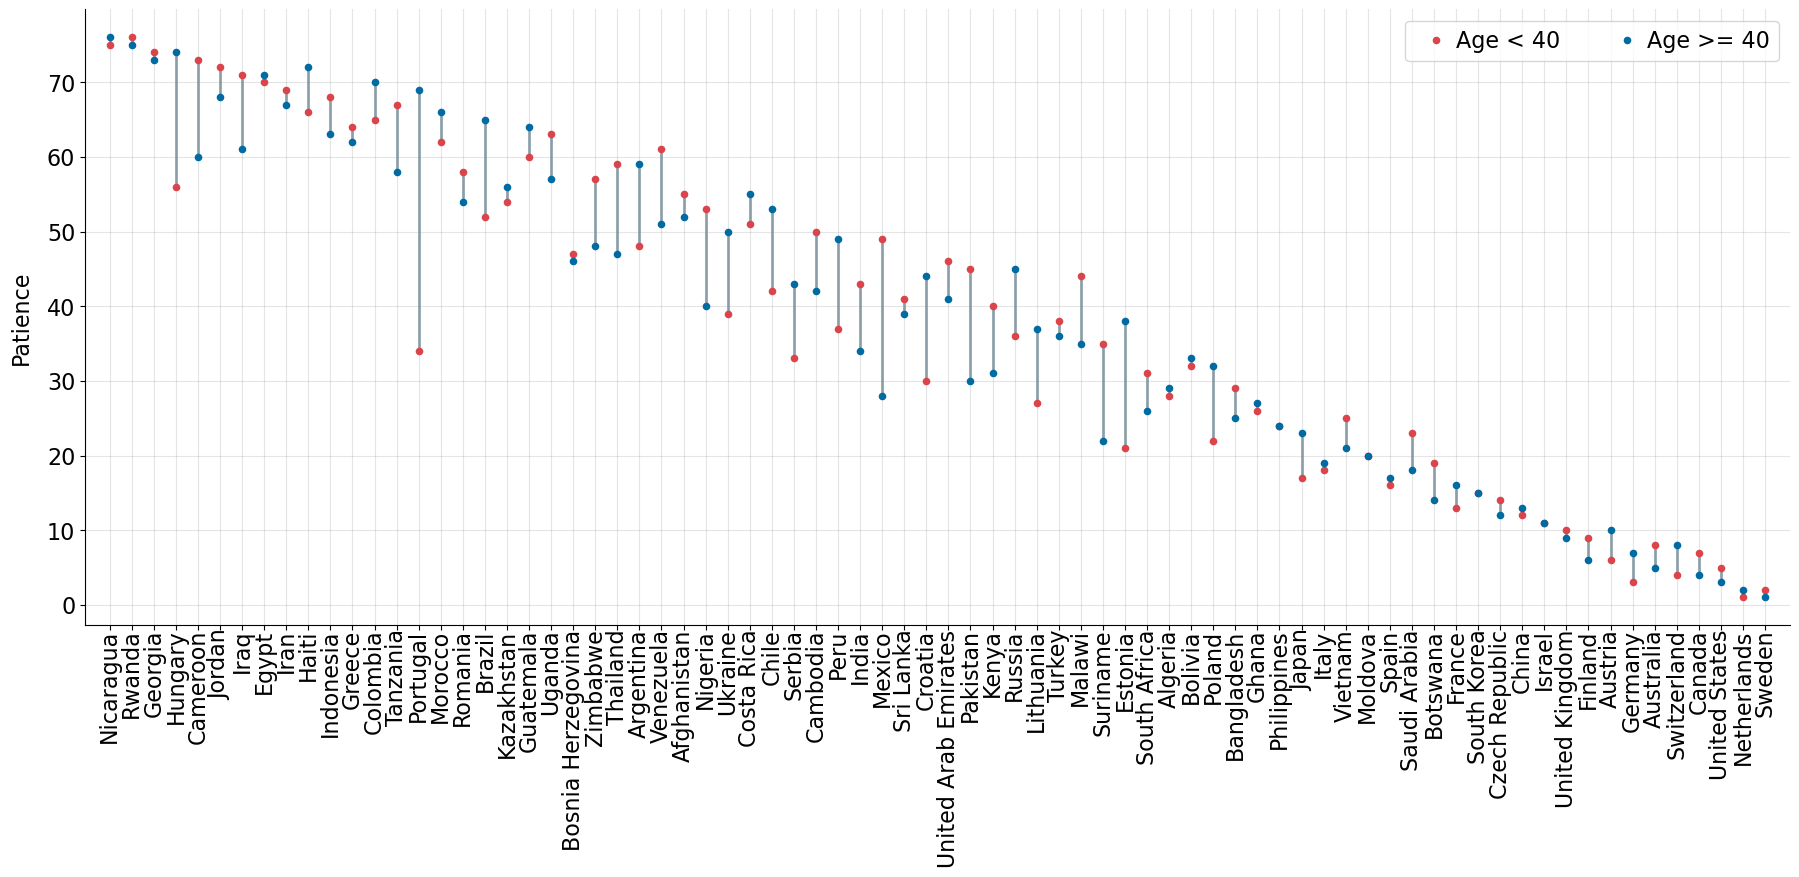

In [35]:
fig, ax = plt.subplots(figsize=(22, 8))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right']].set_visible(False)

# Plot data
# Plot horizontal lines first
ax.vlines(x=df_merged_below_above_40.index, ymin=df_merged_below_above_40["rank_below_40"], ymax=df_merged_below_above_40["rank_above_40"], color='#758D99', zorder=2, linewidth=2, label='_nolegend_', alpha=.8)
# Plot bubbles next
ax.scatter(df_merged_below_above_40.index, df_merged_below_above_40["rank_below_40"], label='Age < 40', s=20, color='#DB444B', zorder=3)
ax.scatter(df_merged_below_above_40.index, df_merged_below_above_40["rank_above_40"], label='Age >= 40', s=20, color='#006BA2', zorder=3)


# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labeltop=False,      # Put x-axis labels on top
                         labelbottom=True,  # Set no x-axis labels on bottom
                         bottom=True,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1,              # Lower tick labels a bit
                         rotation=90,
                         )            


# Set Legend
ax.legend(['Age < 40', 'Age >= 40'], 
          loc='best', #(-.29, 1.03), 
          ncol=2, 
          frameon=True, 
          handletextpad=-.1, 
          handleheight=1,
          fontsize=16,)

ax.margins(x=0.015, tight=True)  
ax.grid(color="grey", alpha=0.2)
ax.set_ylabel("Patience", fontsize=16, labelpad=10)
ax.xaxis.set_label_position('top')

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

#plt.savefig("plots/country_mean_patience_rank_two age_group.png", dpi=300, bbox_inches='tight')

Quantiles

In [36]:
def split_into_quantiles(df):

    df["qage"] = pd.qcut(df["age"], q=5, labels=False).astype(int) + 1 # put each age into quantile group under quantile column "qage"; "..+1" so that the quantile starts from 1 to 10 instead of 0 to 9
    df['qage_labels'] = pd.qcut(df['age'], q=5, labels=[f'Q{i}' for i in range(1, 6)]) # assign labels to the quantiles: "Q1", "Q2"..."Q10"
    
    return df

In [37]:
df_split = split_into_quantiles(df_split)
qage_counts = df_split.groupby(["country", "qage"]).size().reset_index(name="Observation Count")
#groupby for each quantile and calculate the mean patience
df_qage = df_split.groupby(["country", "qage_labels"]).mean("patience").reset_index()
#make pivot table
df_qage = df_qage.pivot(index="country", columns="qage_labels", values="patience")
#merge with country mean
df_merged_quantiles = pd.merge(country_mean, df_qage,  on="country", how="left")
df_merged_quantiles.set_index("country", inplace=True)
plot_data = df_merged_quantiles[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]

C:\Users\Mumu\AppData\Local\Temp\ipykernel_13704\3763088512.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_qage = df_split.groupby(["country", "qage_labels"]).mean("patience").reset_index()


In [40]:
#rank the quantiles 
plot_data["rank_Q1"] = plot_data["Q1"].rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
plot_data["rank_Q2"] = plot_data["Q2"].rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
plot_data["rank_Q3"] = plot_data["Q3"].rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
plot_data["rank_Q4"] = plot_data["Q4"].rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
plot_data["rank_Q5"] = plot_data["Q5"].rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
#plot data quantile 
#keep the columns that are necessary
plot_data_quantile = plot_data[["Q1", "Q2", "Q3", "Q4", "Q5"]]
plot_data_quantile.head()


,Q1,Q2,Q3,Q4,Q5
country,,,,,
Nicaragua,-0.60,-0.60,-0.52,-0.69,-0.89
Rwanda,-0.65,-0.60,-0.58,-0.63,-0.71
Georgia,-0.37,-0.45,-0.49,-0.46,-0.62
Hungary,-0.16,-0.10,-0.38,-0.47,-0.74
Cameroon,-0.38,-0.47,-0.39,-0.38,-0.48


In [41]:
#only keep rank columns
plot_data_ranks = plot_data[["rank_Q1", "rank_Q2", "rank_Q3", "rank_Q4", "rank_Q5"]]
plot_data_ranks
plot_data_ranks.head()

,rank_Q1,rank_Q2,rank_Q3,rank_Q4,rank_Q5
country,,,,,
Nicaragua,75,75,75,76,76
Rwanda,76,76,76,75,74
Georgia,71,73,73,70,72
Hungary,55,46,67,71,75
Cameroon,72,74,69,65,60


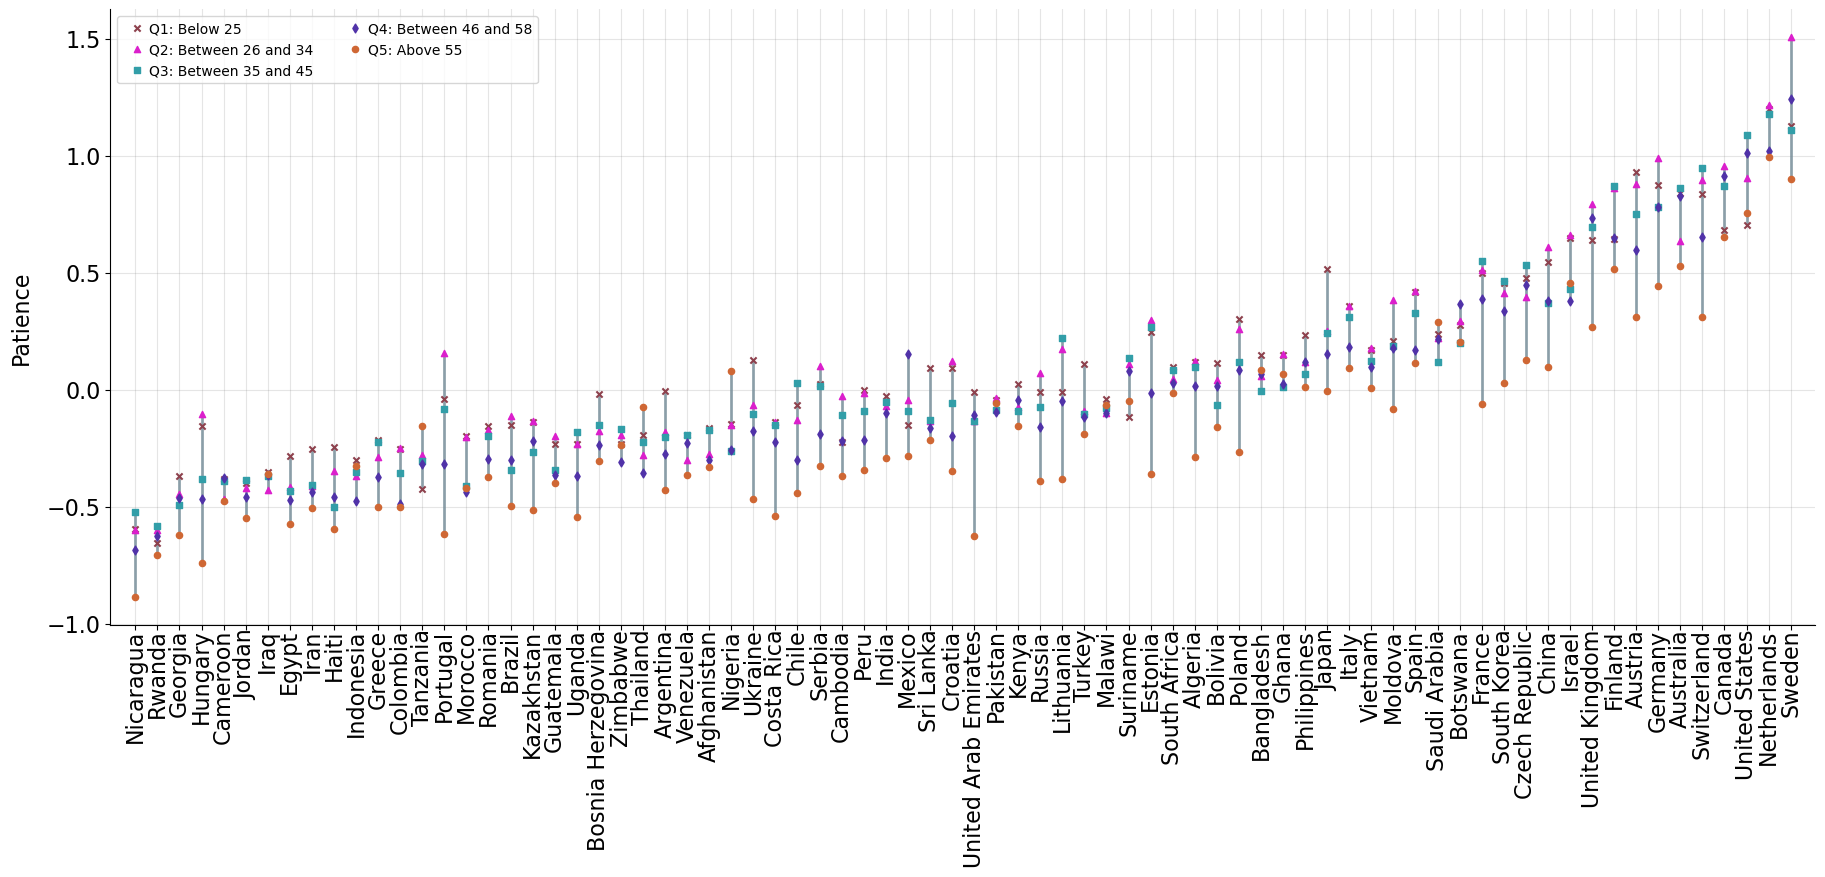

In [43]:
#plot the patience measure for each quantile
fig, ax = plt.subplots(figsize=(22, 8))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right']].set_visible(False)

# Plot data
# Plot horizontal lines first
ax.vlines(x=plot_data_quantile.index, ymin=plot_data_quantile.min(axis=1), ymax=plot_data_quantile.max(axis=1), color='#758D99', zorder=2, linewidth=2, label='_nolegend_', alpha=.8)
# Plot bubbles next
ax.scatter(plot_data_quantile.index, plot_data_quantile["Q1"], label='Q1: Below 25', s=20, color='#8D414D', marker="x", zorder=3)
ax.scatter(plot_data_quantile.index, plot_data_quantile["Q2"], label='Q2: Between 26 and 34', s=20, color='#db1fcc', marker="^", zorder=3)
ax.scatter(plot_data_quantile.index, plot_data_quantile["Q3"], label='Q3: Between 35 and 45', s=20, color='#329ea8', marker="s", zorder=3)
ax.scatter(plot_data_quantile.index, plot_data_quantile["Q4"], label='Q4: Between 46 and 58', s=20, color='#5032a8', marker="d", zorder=3)
ax.scatter(plot_data_quantile.index, plot_data_quantile["Q5"], label='Q5: Above 55', s=20, color='#cf6734', zorder=3) 

#ax.scatter(plot_data.index, plot_data["pl"], label='Age >= 40', s=20, color='#006BA2', zorder=3)


# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labeltop=False,      # Put x-axis labels on top
                         labelbottom=True,  # Set no x-axis labels on bottom
                         bottom=True,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1,              # Lower tick labels a bit
                         rotation=90,
                         )            


# Set Legend
ax.legend( 
          loc='best', #(-.29, 1.03), 
          ncol=2, 
          frameon=True, 
          handletextpad=-.1, 
          handleheight=1)

ax.margins(x=0.015, tight=True)  
ax.grid(color="grey", alpha=0.2)
ax.set_ylabel("Patience", fontsize=16, labelpad=10)
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
#save the plot under the plots folder
plt.show()
#plt.savefig(r"plots/country_mean_patience_quantiles.png", dpi=300, bbox_inches='tight')

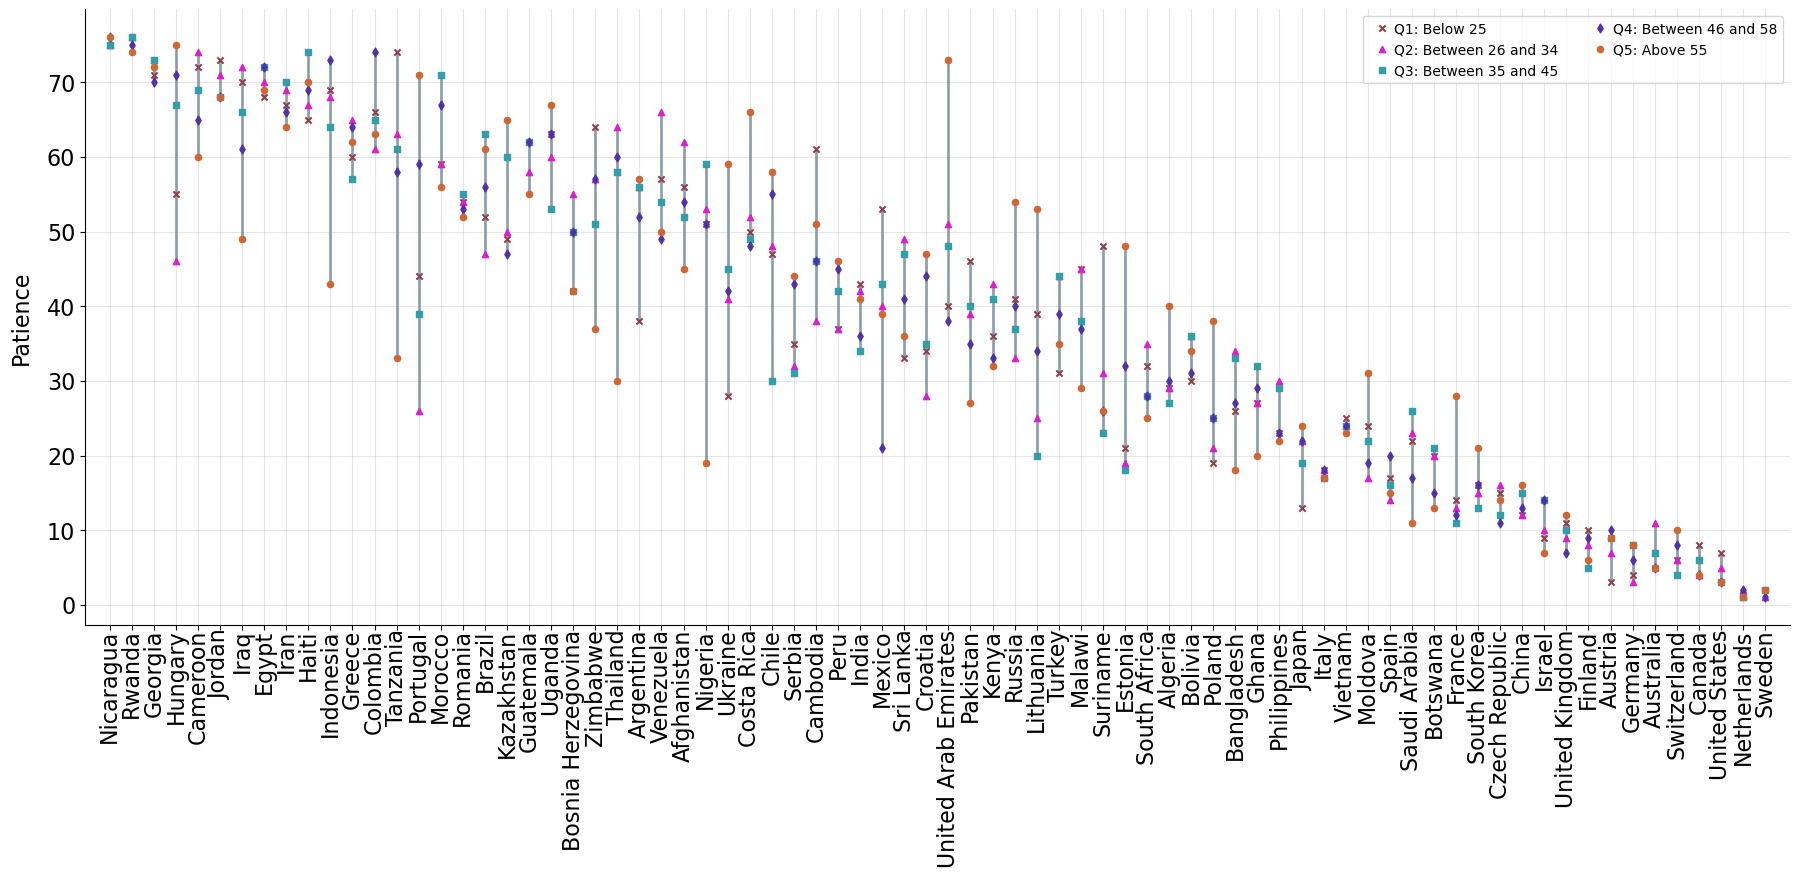

In [44]:
#plot the patience rank for each quantile
fig, ax = plt.subplots(figsize=(22, 8))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right']].set_visible(False)

# Plot data
# Plot horizontal lines first
ax.vlines(x=plot_data_ranks.index, ymin=plot_data_ranks.min(axis=1), ymax=plot_data_ranks.max(axis=1), color='#758D99', zorder=2, linewidth=2, label='_nolegend_', alpha=.8)
# Plot bubbles next
ax.scatter(plot_data_ranks.index, plot_data_ranks["rank_Q1"], label='Q1: Below 25', s=20, color='#8D414D', marker="x", zorder=3)
ax.scatter(plot_data_ranks.index, plot_data_ranks["rank_Q2"], label='Q2: Between 26 and 34', s=20, color='#db1fcc', marker="^", zorder=3)
ax.scatter(plot_data_ranks.index, plot_data_ranks["rank_Q3"], label='Q3: Between 35 and 45', s=20, color='#329ea8', marker="s", zorder=3)
ax.scatter(plot_data_ranks.index, plot_data_ranks["rank_Q4"], label='Q4: Between 46 and 58', s=20, color='#5032a8', marker="d", zorder=3)
ax.scatter(plot_data_ranks.index, plot_data_ranks["rank_Q5"], label='Q5: Above 55', s=20, color='#cf6734', zorder=3) 

#ax.scatter(plot_data.index, plot_data["pl"], label='Age >= 40', s=20, color='#006BA2', zorder=3)


# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labeltop=False,      # Put x-axis labels on top
                         labelbottom=True,  # Set no x-axis labels on bottom
                         bottom=True,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1,              # Lower tick labels a bit
                         rotation=90,
                         )            


# Set Legend
ax.legend( 
          loc='best', #(-.29, 1.03), 
          ncol=2, 
          frameon=True, 
          handletextpad=-.1, 
          handleheight=1)

ax.margins(x=0.015, tight=True)  
ax.grid(color="grey", alpha=0.2)
ax.set_ylabel("Patience", fontsize=16, labelpad=10)
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
#save the plot under the plots folder
plt.show()

#plt.savefig(r"plots/country_mean_patience_ranks_quantiles.png", dpi=300, bbox_inches='tight')